# Heart Disease Classification Model

In [1]:
import zipfile
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import joblib

In [3]:
# Step 1: Extract and Load Data
# Extract the file
with zipfile.ZipFile('Heart.zip', 'r') as zip_ref:
    zip_ref.extractall('heart_data')

# Load the dataset
file_path = 'heart_data/heart.csv'  
df = pd.read_csv(file_path)

# Initial Exploration
print(df.head())
print(df.info())
print(df.describe())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

In [5]:
# Step 2: Clean Data
# Replace 0 values with median in appropriate columns
df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())
df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())

# Step 3: One-Hot Encoding (Only Run Once)
# Convert categorical features into numerical format using one-hot encoding
df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

# Step 4: Outlier Detection and Handling
# Optionally, cap outliers in 'Cholesterol'
q1 = df['Cholesterol'].quantile(0.25)
q3 = df['Cholesterol'].quantile(0.75)
iqr = q3 - q1
threshold = 1.5 * iqr
df['Cholesterol'] = df['Cholesterol'].clip(lower=q1 - threshold, upper=q3 + threshold)

In [7]:
# Data PreProcessing

# Step 5: Data Preprocessing
# Checking for missing values
print(df.isnull().sum())

# Splitting Features and Target
# Note: The target column is 'HeartDisease'
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Splitting the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verify preprocessing steps by checking shapes and sample values
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Age                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
Oldpeak              0
HeartDisease         0
Sex_M                0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina_Y     0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64
Training Features Shape: (734, 15)
Testing Features Shape: (184, 15)
Training Labels Shape: (734,)
Testing Labels Shape: (184,)


In [9]:
# Model Training and Evaluation

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.8586956521739131


In [11]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.8641304347826086


In [13]:
# SVM
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]

print("\nSVM:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        77
           1       0.90      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

Accuracy: 0.8641304347826086


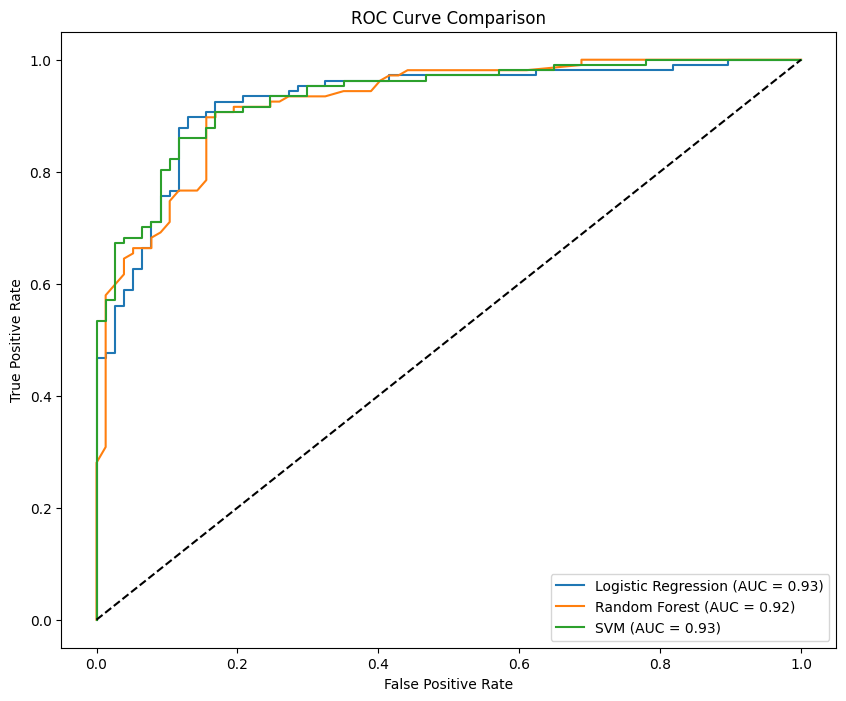

In [15]:
# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_lr)))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_rf)))

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_svm)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Hyperparameter Tuning with GridSearchCV for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


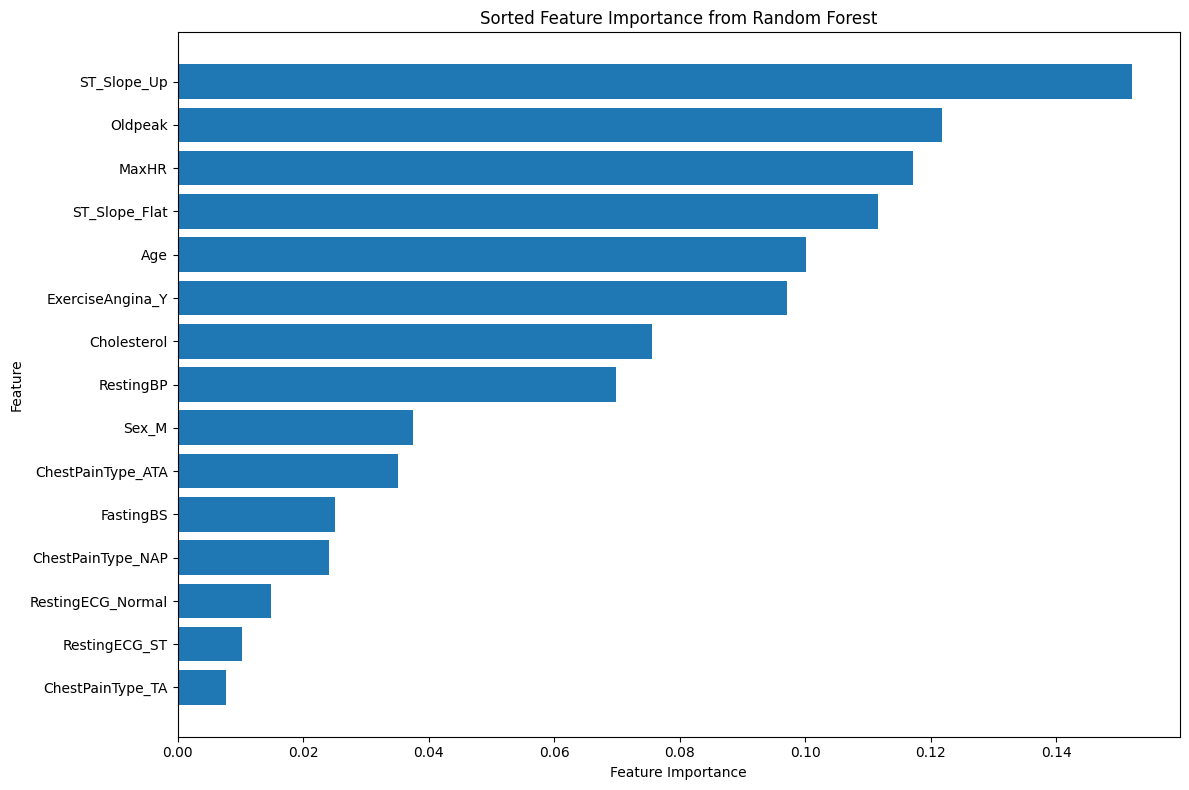

In [19]:
# Feature Importance from Random Forest
best_rf = grid_search_rf.best_estimator_
importances = best_rf.feature_importances_
feature_names = X.columns

# Sort feature importances for better visualization
sorted_indices = np.argsort(importances)

# Plot Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_names)[sorted_indices], importances[sorted_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Sorted Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

In [21]:
# Step 2: Performance Metrics Summary

metrics_data = {
    "Model": ["Logistic Regression", "Random Forest", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    "Precision (Class 1)": [
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["precision"],
        classification_report(y_test, y_pred_rf, output_dict=True)["1"]["precision"],
        classification_report(y_test, y_pred_svm, output_dict=True)["1"]["precision"]
    ],
    "Recall (Class 1)": [
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_rf, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_svm, output_dict=True)["1"]["recall"]
    ],
    "F1-Score (Class 1)": [
        classification_report(y_test, y_pred_lr, output_dict=True)["1"]["f1-score"],
        classification_report(y_test, y_pred_rf, output_dict=True)["1"]["f1-score"],
        classification_report(y_test, y_pred_svm, output_dict=True)["1"]["f1-score"]
    ],
    "AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_svm)
    ]
}

# Create DataFrame to display results
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

                 Model  Accuracy  Precision (Class 1)  Recall (Class 1)  \
0  Logistic Regression  0.858696             0.909091          0.841121   
1        Random Forest  0.864130             0.886792          0.878505   
2                  SVM  0.864130             0.901961          0.859813   

   F1-Score (Class 1)       AUC  
0            0.873786  0.927297  
1            0.882629  0.923899  
2            0.880383  0.933608  


In [23]:
# Step 3: Model Selection

# Save the best model (example: SVM or RandomForest based on evaluation metrics)
best_model = svm  # Modify this to the best model based on evaluation
joblib.dump(best_model, 'best_heart_disease_model.pkl')

# Load the saved model (example usage)
loaded_model = joblib.load('best_heart_disease_model.pkl')

In [25]:
# New Patient Data for Prediction

new_patient_data = {
    'Age': [52],
    'RestingBP': [138],
    'Cholesterol': [175],
    'FastingBS': [0],
    'MaxHR': [125],
    'Oldpeak': [1.2],
    'Sex_M': [1],
    'ChestPainType_ATA': [0],
    'ChestPainType_NAP': [1],
    'ChestPainType_TA': [0],
    'RestingECG_Normal': [1],
    'RestingECG_ST': [0],
    'ExerciseAngina_Y': [0],
    'ST_Slope_Flat': [1],
    'ST_Slope_Up': [0]
}

# Convert to DataFrame
new_patient_df = pd.DataFrame(new_patient_data)

# Scale the new data using the scaler that was used in training
new_patient_scaled = scaler.transform(new_patient_df)

# Predict the outcome using the loaded model
prediction = loaded_model.predict(new_patient_scaled)

# Print the prediction result
if prediction[0] == 1:
    print("The model predicts that the patient has heart disease.")
else:
    print("The model predicts that the patient does NOT have heart disease.")

The model predicts that the patient has heart disease.
